# 📓 Baseline Model 2: HWES with Decomposition Insights


In this notebook, we forecast the **fastest Bitcoin transaction fee (sats/vByte)** for the next 24 hours using **Holt-Winters Exponential Smoothing (HWES)**.

---

### 🧠 Why HWES? Additive or Multiplicative?

We analyzed the seasonality and trend of the time series using both **additive** and **multiplicative** decompositions. Here's what we found:

**✅ Additive Decomposition**

- Seasonal pattern has **constant amplitude** regardless of trend level.
- Works well when seasonality is **independent of the trend level**.
- Residuals look okay but large spikes (likely outliers) are present.

✅ **Multiplicative Decomposition**

- Seasonal component **scales with the level of the series** (i.e., as fees rise, seasonal amplitude increases).
- This fits **real-world Bitcoin fee behavior more accurately**:
    - High congestion periods (e.g., spikes in March) show **amplified seasonal patterns**.
    - Multiplicative seasonality captures this well.
- Residuals are tighter and better-behaved around 0 compared to additive, except for extreme spikes, which are expected.

⚠️ **Note:** Multiplicative models require **strictly positive values**.


### 🔢 Step 1: Import Required Libraries

In [61]:

import pandas as pd
import numpy as np
from itertools import product
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


### 📥 Step 2: Load and Prepare the Data

We load the dataset and apply a small positive shift to avoid issues with multiplicative modeling (HWES cannot handle zero or negative values).

In [62]:

df = pd.read_parquet('../data/processed/preprocessed_sarima_hwes.parquet')

# Count how many values are exactly zero
zero_count = (df['recommended_fee_fastestFee'] == 0).sum()
print(f"Number of zero values in 'recommended_fee_fastestFee': {zero_count}")

# # Add small constant to avoid zeros for multiplicative modeling
# epsilon = 0.01
# df['recommended_fee_fastestFee'] += epsilon

# Full series for final model
series_full = df['recommended_fee_fastestFee'].astype(float).sort_index()
series_full.index.freq = pd.infer_freq(series_full.index)

Number of zero values in 'recommended_fee_fastestFee': 0


In [63]:
series_full.head()

timestamp
2025-03-05 02:10:00    2.0
2025-03-05 02:15:00    2.0
2025-03-05 02:20:00    3.0
2025-03-05 02:25:00    4.0
2025-03-05 02:30:00    2.0
Freq: 5min, Name: recommended_fee_fastestFee, dtype: float64

### ✂️ Step 3: Train-Test Split

We hold out the last 24 hours of the sample as a test set for evaluating different HWES parameter combinations. 

In [64]:

forecast_horizon = 288  # 24 hours * (60 / 5)
train_full = series_full[:-forecast_horizon]
test = series_full[-forecast_horizon:]


### 🔁 Step 4: Extracted Sampled Data and Apply `MinMaxScaler()`

In addition, the last 7-day sample is used for tuning the model parameters. `MinMaxScaler` is used to prevent numerical instability during grid search while the shift ensures values to be strictly positive. After identifying the best model structure, the model is trained on full, real-scale data. 

In [65]:
# Subset for hyperparameter tuning (last 7 days)
train_sampled = train_full.last('7D')
train_sampled.index.freq = pd.infer_freq(train_sampled.index)

# end_time = train_full.index[-1]
# start_time = end_time - pd.Timedelta(days=7)
# series_sampled = train_full.loc[start_time:end_time]

C:\Users\86166\AppData\Local\Temp\ipykernel_44208\525058880.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  train_sampled = train_full.last('7D')


In [66]:
scaler = MinMaxScaler(feature_range=(1, 2))  # Always > 0
train_sampled_scaled = pd.Series(
    scaler.fit_transform(train_sampled.values.reshape(-1, 1)).flatten(),
    index=train_sampled.index
)

In [67]:
# # Create and fit the scaler
# scaler = RobustScaler()
# scaled = pd.Series(
#     scaler.fit_transform(train_sampled.values.reshape(-1, 1)).flatten(),
#     index=train_sampled.index
# )

In [68]:
# # Shift scaled data to be strictly positive
# min_val = scaled.min()
# shift = abs(min_val) + 1e-3 if min_val <= 0 else 0
# scaled_shifted = scaled + shift

# train_sampled_scaled_shifted = pd.Series(scaled_shifted, index=train_sampled.index)

### ⚙️ Step 5: Efficient Hyperparameter Optimization (Additive & Multiplicative)

We test a mix of additive and multiplicative models, prioritizing those that better represent real-world fee dynamics (scaling seasonal effects).

In [69]:

# param_grid = [
#     ('add', 'add', False),
#     ('add', 'add', True),
#     ('mul', 'mul', False),
#     ('mul', 'mul', True),
#     ('add', 'mul', False),
#     ('mul', 'add', False),
#     (None, None, False),
# ]

# Define all grid combinations
trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
damped_options = [True, False]

param_grid = [
    (trend, seasonal, damped)
    for trend, seasonal, damped in product(trend_options, seasonal_options, damped_options)
    if not (trend is None and damped)
]

best_rmse = float('inf')
best_params = None
results = []

for trend, seasonal, damped in param_grid:
    try:
        model = ExponentialSmoothing(
            train_sampled_scaled,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=288 if seasonal else None,
            damped_trend=damped
        )
        fit = model.fit(optimized=True, use_brute=True)
        pred = fit.forecast(forecast_horizon)

        mae = mean_absolute_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        results.append((trend, seasonal, damped, mae, rmse))

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (trend, seasonal, damped)

    except Exception as e:
        print(f"Error with parameters {trend}, {seasonal}, {damped}: {e}")


c:\Users\86166\miniforge3\envs\satcast\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\86166\miniforge3\envs\satcast\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


### ✅ Step 6: Report Best HWES Parameters

In [70]:

best_trend, best_seasonal, best_damped = best_params
print(f"Best HWES parameters: trend={best_trend}, seasonal={best_seasonal}, damped={best_damped}")


Best HWES parameters: trend=mul, seasonal=mul, damped=True


### 🏁 Step 7: Train Final Model on Full Dataset

With the best parameter set identified, we retrain the model on the full dataset to produce a final forecast.

In [71]:

final_model = ExponentialSmoothing(
    train_full,
    trend=best_trend,
    seasonal=best_seasonal,
    seasonal_periods=288 if best_seasonal else None,
    damped_trend=best_damped
)
final_fit = final_model.fit(optimized=True, use_brute=True)
forecast = final_fit.forecast(288)


c:\Users\86166\miniforge3\envs\satcast\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


### 📊 Step 8: Evaluate Forecast Accuracy

We evaluate the forecast using MAE and RMSE on the last 24 hours of actual data from the full dataset.

In [72]:

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"Final Forecast MAE: {mae:.4f}")
print(f"Final Forecast RMSE: {rmse:.4f}")


Final Forecast MAE: 1.2096
Final Forecast RMSE: 1.4747


### 📈 Step 9: Visualize Forecast vs Actual

We plot the historical series (last 7 days), the actual values from the last 24 hours, and the forecast to visually assess model performance.

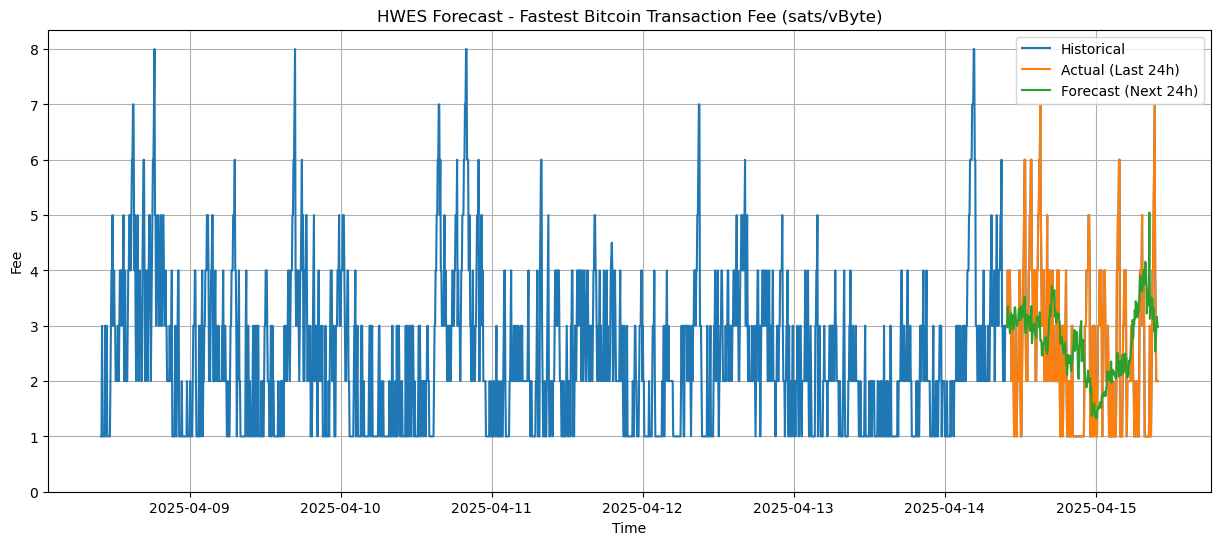

In [75]:

plt.figure(figsize=(15, 6))
plt.plot(series_sampled, label="Historical")
plt.plot(test.index, test, label="Actual (Last 24h)")
plt.plot(test.index, forecast, label="Forecast (Next 24h)")
plt.title("HWES Forecast - Fastest Bitcoin Transaction Fee (sats/vByte)")
plt.xlabel("Time")
plt.ylabel("Fee")
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.show()
